In [1]:
from bayes_opt import BayesianOptimization
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import mlab
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
def unique_rows(a):
    """
    A functions to trim repeated rows that may appear when optimizing.
    This is necessary to avoid the sklearn GP object from breaking

    :param a: array to trim repeated rows from

    :return: mask of unique rows
    """

    # Sort array and kep track of where things should go back to
    order = np.lexsort(a.T)
    reorder = np.argsort(order)

    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1)

    return ui[reorder]

In [3]:
def target(x, y):
    a = np.exp(-( (x - 2)**2/0.7 + (y - 4)**2/1.2) + (x - 2)*(y - 4)/1.6 )
    b = np.exp(-( (x - 4)**2/3 + (y - 2)**2/2.) )
    c = np.exp(-( (x - 4)**2/0.5 + (y - 4)**2/0.5) + (x - 4)*(y - 4)/0.5 )
    d = np.sin(3.1415 * x)
    e = np.exp(-( (x - 5.5)**2/0.5 + (y - 5.5)**2/.5) )
    return 2*a + b - c + 0.17 * d + 2*e

In [4]:
n = 1e5
x = y = np.linspace(0, 6, 300)
X, Y = np.meshgrid(x, y)
x = X.ravel()
y = Y.ravel()
X = np.vstack([x, y]).T[:, [1, 0]]
z = target(x, y)

In [5]:
max(z)

2.0642339183485188

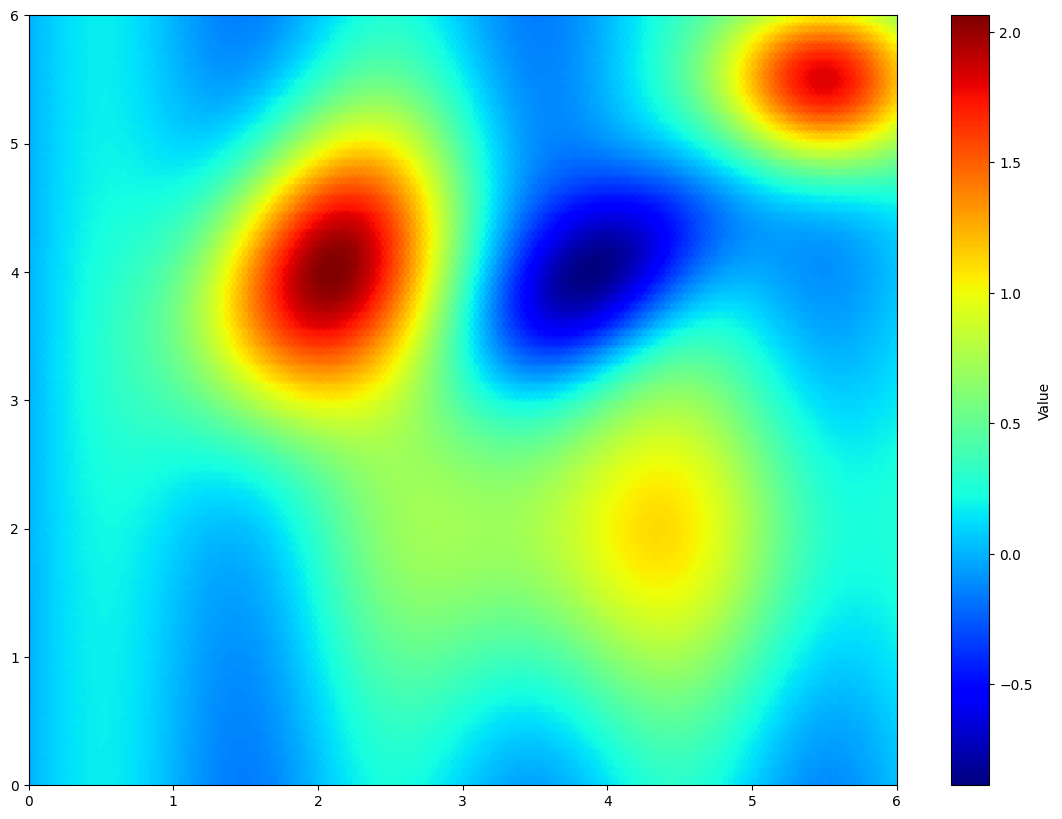

In [6]:
fig, axis = plt.subplots(1, 1, figsize=(14, 10))
gridsize=150

im = axis.hexbin(x, y, C=z, gridsize=gridsize, cmap=cm.jet, bins=None)
axis.axis([x.min(), x.max(), y.min(), y.max()])

cb = fig.colorbar(im)
cb.set_label('Value')

In [15]:
def posterior(bo, X):
    ur = unique_rows(bo.X)
    bo.gp.fit(bo.X[ur], bo.Y[ur])
    mu, sigma2 = bo.gp.predict(X, eval_MSE=True)
    return mu, np.sqrt(sigma2), bo.util.utility(X, bo.gp, bo.Y.max())

def plot_2d(name=None):

    mu, s, ut = posterior(bo, X)

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    gridsize=150

    fig.suptitle('Bayesian Optimization in Action', fontdict={'size':30})

    # GP regression output
    ax[0][0].set_title('Gausian Process Predicted Mean', fontdict={'size':15})
    im00 = ax[0][0].hexbin(x, y, C=mu, gridsize=gridsize, cmap=cm.jet, bins=None)
    ax[0][0].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][0].plot(bo.X[:, 1], bo.X[:, 0], 'D', markersize=4, color='k', label='Observations')

    ax[0][1].set_title('Target Function', fontdict={'size':15})
    im10 = ax[0][1].hexbin(x, y, C=z, gridsize=gridsize, cmap=cm.jet, bins=None)
    ax[0][1].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][1].plot(bo.X[:, 1], bo.X[:, 0], 'D', markersize=4, color='k')
    # ax[0][0].legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    ax[1][0].set_title('Gausian Process Variance', fontdict={'size':15})
    im01 = ax[1][0].hexbin(x, y, C=s, gridsize=gridsize, cmap=cm.jet, bins=None)
    ax[1][0].axis([x.min(), x.max(), y.min(), y.max()])

    ax[1][1].set_title('Acquisition Function', fontdict={'size':15})
    im11 = ax[1][1].hexbin(x, y, C=ut, gridsize=gridsize, cmap=cm.jet, bins=None)

    np.where(ut.reshape((300, 300)) == ut.max())[0]
    np.where(ut.reshape((300, 300)) == ut.max())[1]

    ax[1][1].plot([np.where(ut.reshape((300, 300)) == ut.max())[1]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[1]/50.], 
                  [0, 6], 
                  'k-', lw=2, color='k')

    ax[1][1].plot([0, 6],
                  [np.where(ut.reshape((300, 300)) == ut.max())[0]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[0]/50.], 
                  'k-', lw=2, color='k')

    ax[1][1].axis([x.min(), x.max(), y.min(), y.max()])

    for im, axis in zip([im00, im01, im10, im11], ax.flatten()):
        cb = fig.colorbar(im, ax=axis)
        cb.set_label('Value')
        
    if name is None:
        name = '_'
    
    # pp = PdfPages('bo_eg_' + name + '.pdf')
    # pp.savefig(fig)
    fig.savefig('bo_eg_' + name + '.png')

In [11]:
bo = BayesianOptimization(target, {'x': (0, 6), 'y': (0, 6)})

In [12]:
gp_params = {'corr': 'absolute_exponential', 'nugget': 1e-6}
bo.maximize(init_points=2, n_iter=0, kappa=7)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------


Exception: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported. Instead,please use the "set_gp_params" method to set
 the gp params, and pass an instance of bayes_opt.util.UtilityFunction
 using the acquisition_function argument


In [ ]:
for i in range(150):
    bo.maximize(init_points=0, n_iter=1, acq='ucb', kappa=5, **gp_params)
    plot_2d("{:03}".format(len(bo.X)))

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    3 | 00m01s |    0.52451 |    2.2788 |    5.4574 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    4

/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 | 00m01s |    0.00067 |    0.0000 |    0.0114 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    5 | 00m02s |    0.05287 |    6.0000 |    0.2085 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    6

/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 | 00m02s |   -0.12987 |    1.3525 |    5.9353 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    7 | 00m02s |   -0.01553 |    3.5403 |    0.0994 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    8

/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


 | 00m04s |    0.22718 |    2.6382 |    0.0000 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    9

In [16]:
bo.maximize(init_points=0, n_iter=5)
plot_2d()

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 8         | 1.08      | 4.53      | 2.018     |
| 9         | 0.8936    | 3.977     | 1.556     |
| 10        | 0.7354    | 6.0       | 6.0       |
| 11        | 0.3277    | 4.492     | 6.0       |
| 12        | 0.2313    | 6.0       | 4.581     |


AttributeError: 'BayesianOptimization' object has no attribute 'X'

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
   16 | 00m03s |    0.21952 |    6.0000 |    1.3957 | 
   17 | 00m01s |    0.00065 |    0.0000 |    0.0000 | 
   18 | 00m01s |    1.05420 |    4.1131 |    1.9691 | 
   19 | 00m01s |    0.70754 |    3.6152 |    1.5667 | 
   20 | 00m01s |    0.58663 |    1.4411 |    2.8924 | 


/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


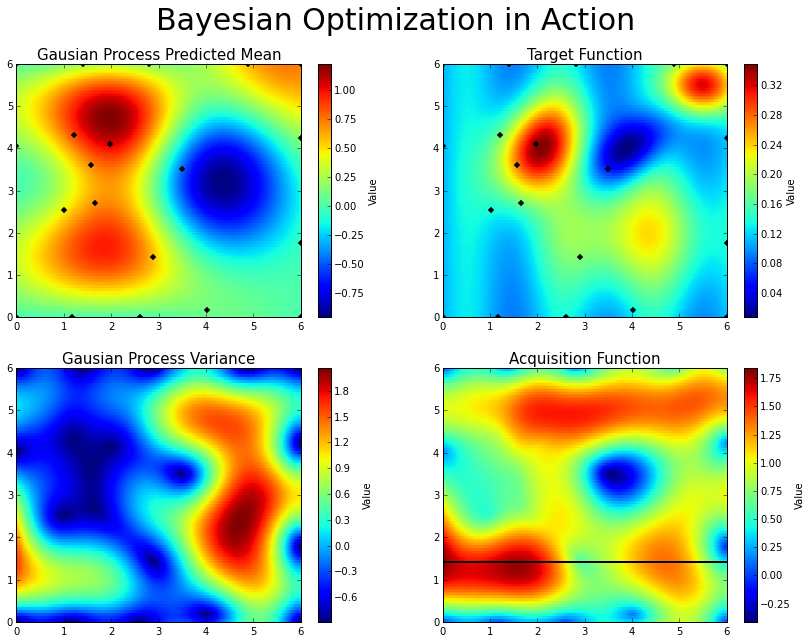

In [12]:
bo.maximize(init_points=0, n_iter=5, acq='ucb', kappa=5, **gp_params)
plot_2d()

/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


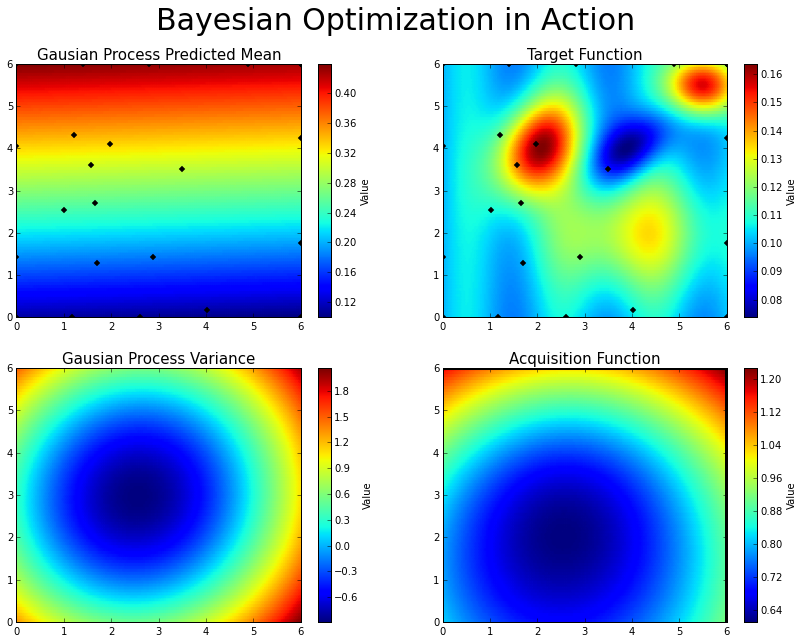

In [16]:
bo.maximize(init_points=0, n_iter=5, acq='ucb', kappa=5, **gp_params)
plot_2d()

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
   26 | 00m02s |    0.73542 |    6.0000 |    6.0000 | 
   27 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   28 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   29 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   30 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   31 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   32 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   33 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   34 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 
   35 | 00m01s |    0.73542 |    6.0000 |    6.0000 | 


/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


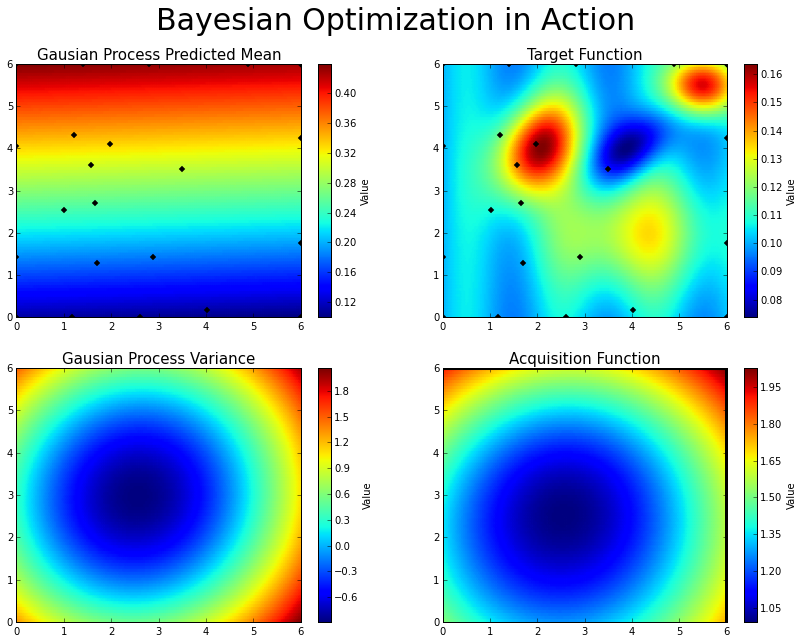

In [17]:
bo.maximize(init_points=0, n_iter=10, acq='ucb', kappa=10, **gp_params)
plot_2d()

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
   46 | 00m01s |    1.26429 |    5.6243 |    5.8933 | 
   47 | 00m00s |    1.22449 |    5.9439 |    5.6893 | 
   48 | 00m00s |    0.07703 |    5.5254 |    4.4820 | 
   49 | 00m00s |    0.07643 |    5.9776 |    0.5025 | 
   50 | 00m00s |    1.23195 |    5.9893 |    5.5104 | 


/Users/fmfnogueira/venvs3/general/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


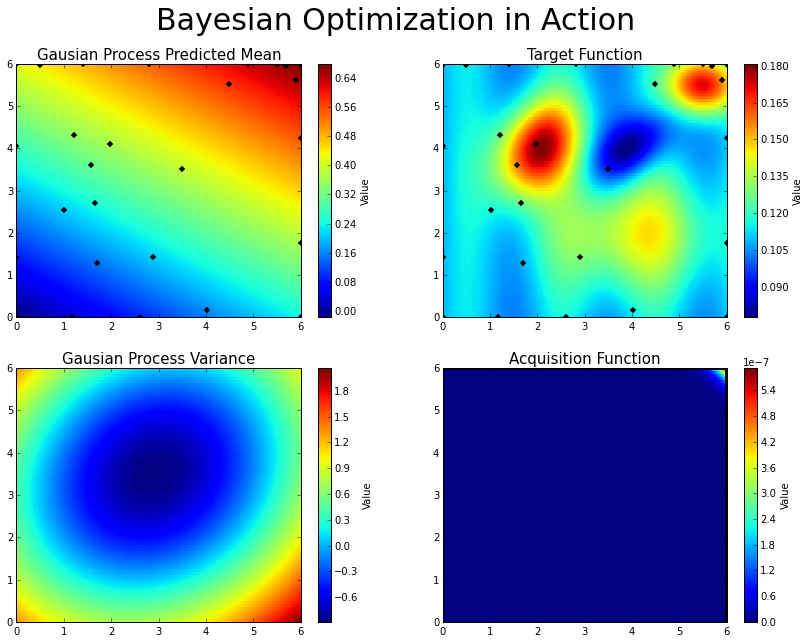

In [19]:
bo.maximize(init_points=0, n_iter=5, acq='ei', kappa=0.1, **gp_params)
plot_2d()